In [1]:
import sys, os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import random
#from iowa_env import Iowa_Gambling_Task
from IPython.display import clear_output
from pandas import DataFrame
import json

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

# 환경 클래스 정의
class Iowa_Gambling_Task(gym.Env):
    def __init__(self):
        super(Iowa_Gambling_Task, self).__init__() ## 부모 클래스 생성자 호출

        ## variable
        self.action_space = gym.spaces.Discrete(4) ## A,B,C,D 4가지 선택지
        self.score = 2000 ##사람이 가지고 있는 돈 ## 처음 시작하는 돈
        self.observation_space = 0 ## 임의로 0으로 둠
        self.current_step = 0 ## 현재 step ## 첫 step = 0

        ## memeory
        self.choices = [] ## 지금까지 한 선택들
        self.rewards = [] ## 지금까지 받은 reward들

    def create_deck_rewards(self, action):
        ## reward
        positive_rewards ={
            0 : 100, #A
            1 : 100, #B
            2 : 50, #C
            3 : 50  #D
        }

        negative_rewards={ ## lambda : 쓰는 이유: 선택할 때마다 바뀌게 하기 위해서
            0 : lambda : np.random.choice([0, 150, 200, 250, 300, 350], p =[1/6, 1/6, 1/6, 1/6, 1/6, 1/6]),## A
            1 : lambda : np.random.choice([0, 1250], p =[0.9, 0.1]),## B
            2 : lambda : np.random.choice([0, 25, 75, 50], p =[0.5, 0.1, 0.1, 0.3]), ## C
            3 : lambda : np.random.choice([0, 250], p =[0.9, 0.1]) ## D
        }

        return positive_rewards[action], negative_rewards[action]()

    def reset(self):
        self.rewards = []
        self.choices = []
        self.current_step = 0
        self.score = 2000
        return 0, {}

    def step(self, action):
        ## reward 계산
        pos_r , neg_r = self.create_deck_rewards(action)
        reward = pos_r -  neg_r

        ## memory
        self.choices.append(action)
        self.rewards.append(reward)

        ## reward 반영
        self.score += reward
        self.current_step += 1 ## 현재 step 갱신

        ## 게임 끝났는 지 판단
        done = False
        if self.score<=0:
            done = True

        ## info
        info = {
            "positive_reward" : pos_r,
            "negative_reward" : neg_r
        }

        return 0, reward, done, info

    def get_history(self): ## 선택과 reward return
        return self.choices, self.rewards

    def get_score(self): ## score return
        return self.score

    def render(self): ## render
        print(f"Step : {self.current_step}, Score : {self.score}")

In [3]:
class VSQagent: ## define VS Q learning agent
    def __init__(self, pos_learning_rate, neg_learning_rate, beta, gamma, get_legal_actions, q_weight = 0.5):
        self.get_legal_actions = get_legal_actions
        self.pos_qvalues  = defaultdict(lambda: defaultdict(lambda: 0.0))
        self.neg_qvalues  = defaultdict(lambda: defaultdict(lambda: 0.0))
        self.pos_learning_rate = pos_learning_rate
        self.neg_learning_rate = neg_learning_rate
        self.beta = beta
        self.gamma = gamma
        self.q_weight = 0.5 ##1에 가까울 수록 긍정적 보상에 비중을 더 줌. 반대로 0에 가까울 수록 부정적 보상에 비중을 더 줌.

    def get_qvalue(self, state, action):
        return self.q_weight * self.pos_qvalues[state][action]-(1-self.q_weight)*self.neg_qvalues[state][action]

    def get_pos_q_value(self, state):
        ## state에 대한 pos_q_value return 하기
        #V(s) = max_a Q(state,action) 이용하기
        possible_actions = self.get_legal_actions(state) ## 가능한 action 가져오기
        if not possible_actions:
            return 0.0
        # Ensure qvalues are floats for max comparison
        pos_q_values = [] ## q_value를 보관할 리스트
        for action in possible_actions: ## 가능한 행동의 q_value들을 리스트에 삽입하기
          pos_q_values.append(self.pos_qvalues[state][action])
        value = max(pos_q_values) ## 가장 높은 q_value 찾기
        return value

    def get_neg_q_value(self, state):
        ## state에 대한 neg_q_value return 하기
        #V(s) = max_a Q(state,action) 이용하기
        possible_actions = self.get_legal_actions(state) ## 가능한 action 가져오기
        if not possible_actions:
            return 0.0
        # Ensure qvalues are floats for max comparison
        neg_q_values = [] ## q_value를 보관할 리스트
        for action in possible_actions: ## 가능한 행동의 q_value들을 리스트에 삽입하기
          neg_q_values.append(self.neg_qvalues[state][action])
        value = max(neg_q_values) ## 가장 높은 q_value 찾기
        return value


    def update(self, state, action, pos_r, neg_r, next_state):
        # Q(s,a) += learning_rate * (r + gamma * V(s') - Q(s,a))
        gamma = self.gamma
        pos_learning_rate = self.pos_learning_rate
        neg_learning_rate = self.neg_learning_rate

        # 현재 state, action q value
        pos_q = self.pos_qvalues[state][action]
        neg_q = self.neg_qvalues[state][action]

        ## next state q value
        next_pos_q = self.get_pos_q_value(next_state)
        next_neg_q = self.get_neg_q_value(next_state)

        ## update
        self.pos_qvalues[state][action] += pos_learning_rate * (pos_r+gamma*next_pos_q - pos_q)
        self.neg_qvalues[state][action] += neg_learning_rate * (neg_r+gamma*next_neg_q - neg_q)


    def softmax(self, q_values):
        q_values = np.array(q_values) ## q_values를 np.array로 변환
        nor_q_values = q_values-np.max(q_values)
        beta_q_values = self.beta * nor_q_values ## beta 곱하기
        exp_q_values  = np.exp(beta_q_values) ## exp
        probs = exp_q_values/np.sum(exp_q_values) ## 밑 나누기
        return probs


    def get_action(self, state):
        possible_actions = self.get_legal_actions(state) ## 가능한 행동 가져오기
        if not possible_actions:
            return None

        q_values = []
        for action in possible_actions:
            q_values.append(self.get_qvalue(state,action))
        probs = self.softmax(q_values)
        chosen_action = np.random.choice(possible_actions, p=probs)
        return chosen_action


In [4]:
def play_and_train(env, agent, t_max=10**2): ## 한 번의 에피소드를 돌리는 것임.
    """ Runs one episode, trains the agent, returns total reward. """
    total_reward = 0.0
    pos_q_values, neg_q_values = [], [] ## positive q_value, negative q_value
    s, info = env.reset() # Use gymnasium reset signature
    rewards = [2000]
    for t in range(t_max):
        a = agent.get_action(s)
        if a is None: # Handle cases where no actions are possible (shouldn't happen in these envs)
             break
        
        # Use gymnasium step signature
        next_s, r, terminated, info = env.step(a)

        pos_q_values.append([agent.pos_qvalues[s][0], agent.pos_qvalues[s][1], agent.pos_qvalues[s][2], agent.pos_qvalues[s][3]]) 
        neg_q_values.append([agent.neg_qvalues[s][0], agent.neg_qvalues[s][1], agent.neg_qvalues[s][2], agent.neg_qvalues[s][3]])

        pos_r , neg_r = info["positive_reward"], info["negative_reward"]

        # Train the agent
        agent.update(s, a, pos_r, neg_r, next_s)

        s = next_s
        total_reward += r
        rewards.append(total_reward+2000)
        if terminated : # Use gymnasium termination flags
            break


    return total_reward, pos_q_values, neg_q_values, rewards

In [5]:
with open('params_ours.json', 'r', encoding='utf-8') as f:
    parameters = json.load(f)
parameters[0]

{'subj': 1,
 'q_alpha': 8.475266633192015e-05,
 'q_beta': 259.7964685233356,
 'vs_alpha_plus': 6.30006994395163e-05,
 'vs_alpha_minus': 0.000493060175549682,
 'vs_beta': 738.1551533071688,
 'vs_w': 0.9576385044218695,
 'nll_q': 92.35725715120611,
 'nll_vs': 75.81035845189355}

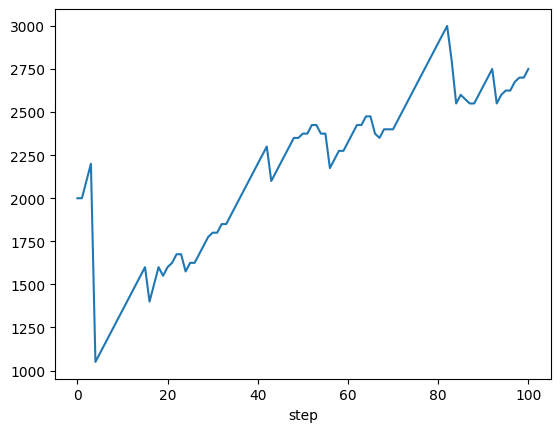

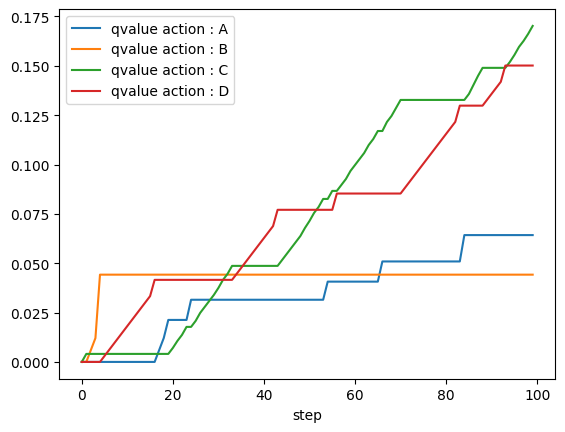

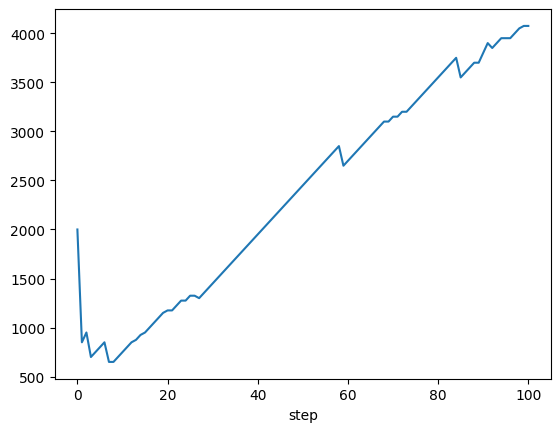

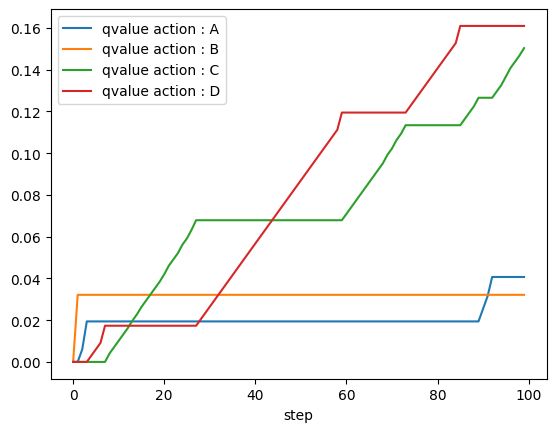

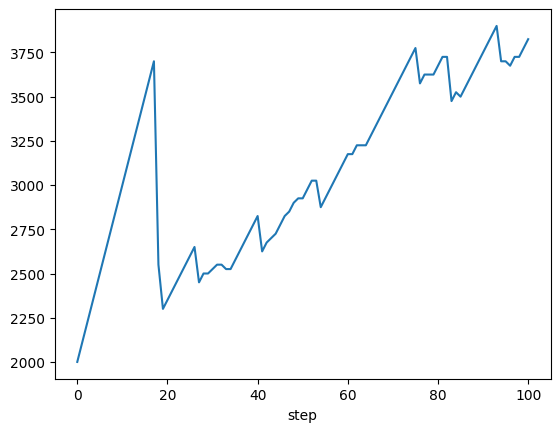

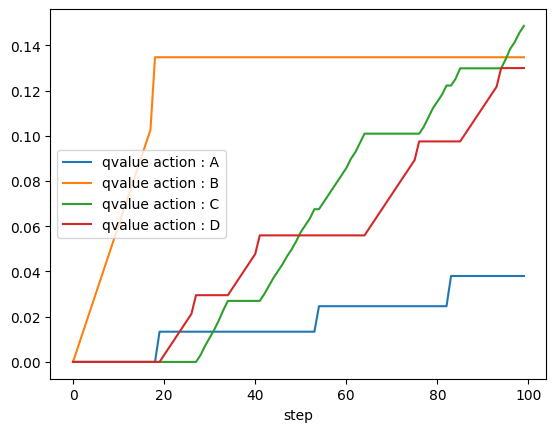

In [6]:
for index, key in enumerate(parameters):
    many_trial_q_values = [] 
    env = Iowa_Gambling_Task()
    env.reset()
    n_actions = env.action_space.n

    ## agent 정의
    agent = VSQagent(pos_learning_rate=parameters[0]['vs_alpha_plus'], neg_learning_rate=parameters[0]['vs_alpha_minus'], beta=parameters[0]['vs_beta'], gamma=0.99,
                       get_legal_actions=lambda s: range(n_actions), q_weight = parameters[0]['vs_w']) # 강승수
    q_weight = parameters[0]['vs_w']
    for i in range(1):
        total_reward, pos_q_values, neg_q_values, rewards = play_and_train(env, agent)
        pos_q_values = np.array(pos_q_values)
        neg_q_values = np.array(neg_q_values)
        q_values = q_weight*pos_q_values+(1-q_weight)*neg_q_values
        plt.xlabel("step")
        plt.plot(rewards)
        plt.show()
        for action in range(4):
            plt.plot(q_values[:, action], label = f"qvalue action : {chr(action+65)}")

        plt.xlabel("step") ## 이부분 상아님게 말씀드리기
        plt.legend()
        plt.show()